## Fine-tuning RUDOLPH on text QA

RUDOLPH был обучен на 4-х задачах (text2image, image2text и text2text), причем предобучение на задачу генерации текста осуществлялось только в левых текстовых токенах. Использование данных задач для предобучения позволяет модели научиться сопоставлять тексты и картинки, а также кодировать лингвистическую информацию о естественном языке в генерируемые векторные представления.

После пре-трейна, RUDOLPH может быть дообучен под более узкую задачу, для которой входом или выходом является текст, картинка либо их комбинация.

В данном ноутбуке описан процесс дообучения RUDOLPH 2.7B под текстовую задачу ответа на вопросы по данному текстн (machine reading comprehension (MRC)).

# Данные

Используем данные из набора [sberQuAD](https://huggingface.co/datasets/sberquad) - это датасет, содержащий текстовый абзац, вопрос по прочитанному тексту и фрагмент текста, являющийся ответом на заданный вопрос.

Размер датасета:

* train: 45328 
* validation: 5036
* test: 23936

Cделаем импорт необходимых зависимостей

In [1]:
!pip install rudolph==0.0.1rc10 

In [2]:
import torch
from rudalle import get_vae
from rudalle.utils import seed_everything

import sys
sys.path.insert(0, 'ru-dolph')

import os
from glob import glob
from os.path import join
from datetime import datetime

import torch
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import torchvision
import transformers
import more_itertools
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tqdm.auto import tqdm
from einops import rearrange
import youtokentome as yttm

import torchvision
from rudalle.image_prompts import ImagePrompts
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph import utils
from rudolph.model.utils import get_attention_mask
from rudalle import get_tokenizer, get_vae
from rudolph.api import ruDolphApi

import datasets
import random

In [3]:
device = 'cuda'

In [4]:
model = get_rudolph_model('2.7B', pretrained=True, fp16=True, device='cuda')

/home/jovyan/.imgenv-a100-0/lib/python3.7/site-packages/huggingface_hub/file_download.py:624: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/5.33G [00:00<?, ?B/s]

In [5]:
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


## Данные для обучения

Выгрузим данные с помощью библиотеки datasets.

In [6]:
from datasets import list_datasets
dataset = datasets.load_dataset('sberquad')

Reusing dataset sberquad (/home/jovyan/.cache/huggingface/datasets/sberquad/sberquad/1.0.0/62115d937acf2634cfacbfee10c13a7ee39df3ce345bb45af7088676f9811e77)


  0%|          | 0/3 [00:00<?, ?it/s]

Нам понадобятся три поля, содержащихся в наборе (`'context'`, `'question'`, `'answers'`)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 45328
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5036
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 23936
    })
})

In [8]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [9]:
print('Контекст + вопрос: ', train_data['context'][0] + train_data['question'][0])
print('-'*100)
print('Ответ: ', train_data['answers'][0]['text'])

Контекст + вопрос:  В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.чем представлены органические остатки?
----------------------------------------------------------------------------------------------------
Ответ:  ['известковыми выделениями сине-зелёных водорослей']


## Подготовка загрузчика данных

Fine-tuning RUDOLPH-а будум проводить следующим образом: контекст и вопрос будем подавать в левые текстовые токены, а ответ на вопрос будем ожидать в правых текстовых токенах. Вместо токенов изображения подаются нули.

При предобучении RUDOLPH-а использовался набор спец-символов для левых и правых текстовых токенов, который служил для определения типа решаемой задачи (`<LT_T2I>` и `<LT_T2I>`).

Добавим в словарь дополнительные спец-символы (`<LT_TQA>` и `<LT_TQA>`), которые добавляются в начало левых и правых текстовых токенов, соответственно. С помощью данных спец-токенов добавляем модели знания о решаемой задаче.

Входная последовательность будет выглядеть следующим образом: 
```<BOS> <LT_TQA> <context> <question> <EOS>``` ```<zeros-image-tokens>```
```<BOS> <RT_TQA> <answer> <EOS>```

In [9]:
class Args():
    def __init__(self, model, checkpoint_path):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 1
        self.save_path= checkpoint_path
        self.model_name = 'rudolph_sberquad_'
        self.save_every = 1000
        self.bs = 4
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 0.01
        self.rt_loss_weight = 7
        self.image_size = self.image_tokens_per_dim * 8
        
checkpoint_path = './model/checkpoints/'
args = Args(model, checkpoint_path)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [10]:
SPC_TOKENS = {
    '<LT_UNK>': 16384,
    '<RT_UNK>': 16385,
    '<LT_T2I>': 16386,
    '<LT_I2T>': 16387,
    '<LT_T2T>': 16388,
    '<RT_I2T>': 16389,
    
    '<LT_TQA>': 16390,
    '<RT_TQA>': 16391,
}

# Dataset

In [11]:
class SQuADDataset(Dataset):
    spc_id = -1
    
    def __init__(self, dataset, tokenizer, args):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.args = args
        self.spc_tokens = SPC_TOKENS
        
    def __len__(self):
        return len(self.dataset)
    
    def encode_text(self, text, text_seq_length, add_special = True):
        tokens = self.tokenizer.tokenizer.encode([text], output_type=yttm.OutputType.ID)[0]
        bos = [self.tokenizer.bos_id]
        if add_special:
            bos.append(self.spc_id)
        tokens = bos + tokens + [self.tokenizer.eos_id]
        return self.tokenizer.prepare_tokens(tokens, text_seq_length)
   
    def __getitem__(self, item):
        
        left_text = self.dataset['context'][item] + ' ' + self.dataset['question'][item]
        right_text = self.dataset['answers'][item]['text'][0]
        
        left_special_token = '<LT_TQA>'
        right_special_token = '<RT_TQA>'
        
        left_text = left_text.lower().strip()
        left_encoded_text = self.encode_text(left_text, text_seq_length=self.args.l_text_seq_length)
        left_encoded_text[torch.where(left_encoded_text == self.spc_id)] = self.spc_tokens[left_special_token]
        
        right_text = right_text.lower().strip()
        right_encoded_text = self.encode_text(right_text, text_seq_length=self.args.r_text_seq_length)
        right_encoded_text[torch.where(right_encoded_text == self.spc_id)] = self.spc_tokens[right_special_token]
        
        return left_encoded_text, right_encoded_text
    

Функция для декодирования последовательности текстовых токенов.

In [12]:
def decode_text(tokenizer, encoded, ignore_ids):
    return tokenizer.tokenizer.decode(encoded.cpu().numpy().tolist(), ignore_ids=ignore_ids)[0]

Посмотрим на датасет

In [13]:
dataset_qa = SQuADDataset(train_data, tokenizer, args)

In [14]:
idx = random.randint(0, len(dataset_qa)-1)
left_encoded_text, right_encoded_text = dataset_qa[idx]

In [15]:
spc_id = -1

In [16]:
# Токены, которые будут игнорироваться токенизатором при декодировании.
ignore_ids = [
    tokenizer.eos_id, tokenizer.bos_id, tokenizer.unk_id, tokenizer.pad_id,
    spc_id, *list(SPC_TOKENS.values())
]

In [17]:
print('Контекст + Вопрос: ', decode_text(tokenizer, left_encoded_text, ignore_ids))
print('Ответ: ', decode_text(tokenizer, right_encoded_text, ignore_ids))

Контекст + Вопрос:  половая зрелость может наступать в разные сроки и при разной длине. как правило, половое созревание наступает у самцов окуня в возрасте 2—3 лет[27][109], у самок — несколько позднее, в 4—5 лет[155]. для некоторых водоёмов, например, для озёр убинское (новосибирская область), тразимено (италия) и пауни (новая зеландия), отмечены случаи, когда окунь становился половозрелым в возрасте 1 года[7][156]. у окуней из низовий енисея половое созревание может наступить только в 6 лет[156], а в озере хубсугул — в 7 лет[45]. отмечалось увеличение возраста полового созревания самок в реках после создания водохранилищ[157]. когда наступает половое созревания у окуней в озере хубсугул?
Ответ:  в 7 лет


## RUDOLPH fine-tuning

In [18]:
try:
    if args.wandb:
        wandb.init(project = args.model_name)
except:
    args.wandb = False
    print('If you want to use wandb logs pls login via wandb -login')

Можно заморозить некоторые веса модели для ускорения процесса обучения.

In [19]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [21]:
train_dataloader = DataLoader(dataset_qa, batch_size=args.bs, shuffle=True, drop_last=True)

In [22]:
model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=args.lr, final_div_factor=500, 
    steps_per_epoch=len(train_dataloader), epochs=args.epochs
)

In [23]:
def load_checkpoint(model, optimizer, losslogger, filename='checkpoint.pt'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [24]:
def train(model, optimizer, scheduler, args: Args, train_dataloader, from_checkpoints = False):
    """
      args - arguments for training

      train_dataloader - SQuADDataset class with text_q - text_a pairs in batch
      """
    loss_logs = []
    try:
        t_steps = len(train_dataloader)*args.epochs
        progress = tqdm(total = t_steps, desc='🦌🦌🦌finetuning process🦌🦌🦌')
    
        save_counter = 0
        start_epoch = 0
        
        if from_checkpoints:
            model, optimizer, start_epoch, loss_logs = load_checkpoint(model, optimizer, loss_logs, filename=os.path.join(args.save_path,f"rudolph_sberquad_state6.pt"))

        for epoch in range(start_epoch, args.epochs):
      
          for encoded_left_text, encoded_right_text in train_dataloader: #, prompt, word
        
            bs_text = encoded_left_text.shape[0]
        
            save_counter+=1

            model.zero_grad()

            image_seq_length = args.image_tokens_per_dim ** 2
            total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
        
            attention_mask_text = get_attention_mask(bs_text, args.l_text_seq_length,
                                                 args.image_tokens_per_dim, 
                                                 args.r_text_seq_length, args.device)
        
            image_input_ids_text = torch.zeros((bs_text, image_seq_length), dtype=torch.int32).to(args.device)
            input_ids_text = torch.cat((encoded_left_text.to(args.device), image_input_ids_text, encoded_right_text.to(args.device)), dim=1)
        
            loss, loss_values = model.forward(input_ids_text, attention_mask_text, 
                                                             lt_loss_weight=args.lt_loss_weight,
                                                             img_loss_weight=args.img_loss_weight, 
                                                             rt_loss_weight=args.rt_loss_weight, return_loss=True)
            

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if save_counter % args.save_every == 0:
                print(f'Saving checkpoint here {args.model_name}_rudolph_{save_counter}.pt')
                plt.plot(loss_logs)
                plt.show()
                state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict(), 'losslogger': loss_logs}
                torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}rudolph_{save_counter}.pt")
                )
                torch.save(
                    state,
                    os.path.join(args.save_path,f"{args.model_name}state_{save_counter}.pt")
                )

            if args.wandb:
                wandb.log({"loss":  loss.item()})
            loss_logs+=[loss.item()]
            progress.update()
            progress.set_postfix({"loss": loss.item()})
    
        print(f'Complitly tuned and saved here  {args.model_name}__textqa_last.pt')
        plt.plot(loss_logs)
        plt.show()
        torch.save(
            model.state_dict(),
            os.path.join(args.save_path,f"{args.model_name}textqa_last.pt")
        )
    except KeyboardInterrupt:
    
    
        print(f'What for did you stopped? Please change model_path to /{args.save_path}/{args.model_name}_rudolf_Failed_train')
        plt.plot(loss_logs)
        plt.show()
    
        torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_rudolf_Failed_train.pt")
                )
    except Exception as err:
        print(f'Failed with {err}')

In [25]:
#!rm -r ./model/checkpoints

In [26]:
#!mkdir ./model/checkpoints

🦌🦌🦌finetuning process🦌🦌🦌:   0%|          | 0/11332 [00:00<?, ?it/s]

Saving checkpoint here rudolph_sberquad__rudolph_1000.pt


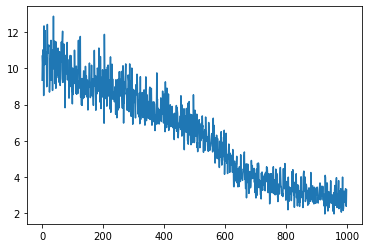

Saving checkpoint here rudolph_sberquad__rudolph_2000.pt


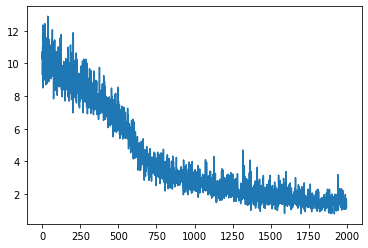

Saving checkpoint here rudolph_sberquad__rudolph_3000.pt


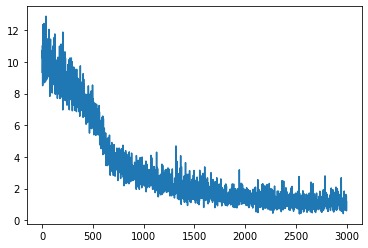

Saving checkpoint here rudolph_sberquad__rudolph_4000.pt


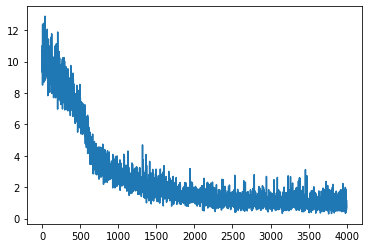

Saving checkpoint here rudolph_sberquad__rudolph_5000.pt


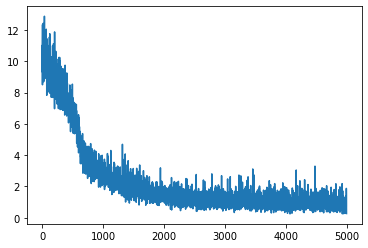

Saving checkpoint here rudolph_sberquad__rudolph_6000.pt


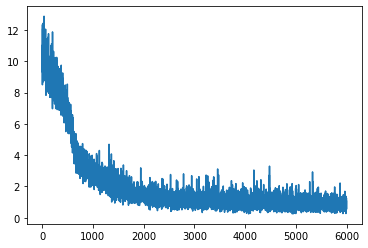

Saving checkpoint here rudolph_sberquad__rudolph_7000.pt


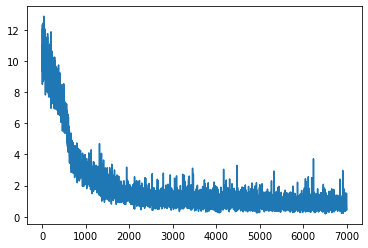

Saving checkpoint here rudolph_sberquad__rudolph_8000.pt


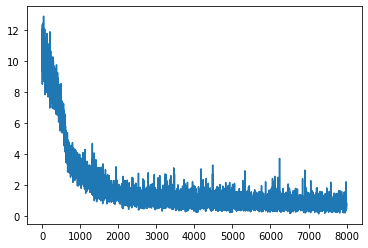

Saving checkpoint here rudolph_sberquad__rudolph_9000.pt


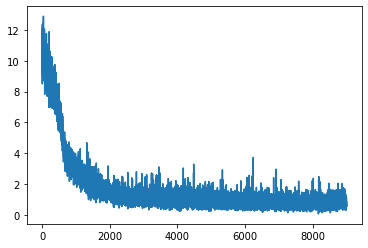

Saving checkpoint here rudolph_sberquad__rudolph_10000.pt


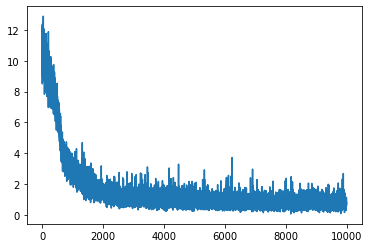

Saving checkpoint here rudolph_sberquad__rudolph_11000.pt


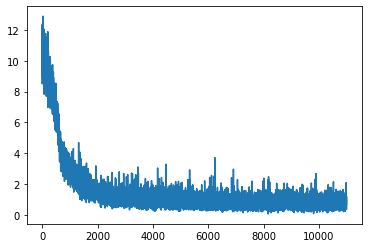

Complitly tuned and saved here  rudolph_sberquad___textqa_last.pt


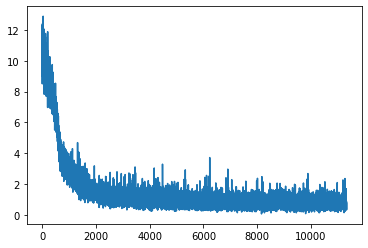

In [27]:
model = freeze(
    model=model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
) 

train(model, optimizer, scheduler, args, train_dataloader)

## Inference 

Итак, RUDOLPH научился отвечать на вопросы по прочитанному тексту, время посмотреть на ответы.

В классе RuDolphApi присутствует большое количество методов для запуска RUDOLPH-а на разнообразных задачах (generate_text - для генерации текста в левых токенах, image_captioning - генерация описания изображения, dream - генерация изображения по запросу, ...)

Для получения ответов в необходимом нам формате создадим собственный класс ruDolphTextQAApi, который наследует от ruDolphApi, и определим в нем функцию generate_text_answers, которая принимает на вход левые текстовые токены и токены изображения и генерирует ответ в правых текстовых токенах.

In [29]:
class ruDolphTextQAApi(ruDolphApi):
    def __init__(self, model, tokenizer, vae, spc_tokens=None, quiet=False, *, bs=24, q=0.5, txt_top_k=64,
                 img_top_k=768, txt_top_p=0.8, img_top_p=0.99, txt_temperature=0.9, img_temperature=1.0):
        
        super().__init__(model = model, tokenizer = tokenizer, vae = vae, spc_tokens = spc_tokens, quiet = quiet, bs = bs, q = q, txt_top_k = txt_top_k,
                 img_top_k = img_top_k, txt_top_p = txt_top_p, img_top_p = img_top_p, txt_temperature = txt_temperature, img_temperature = img_temperature)
    
    def generate_text_answers(self, image_tokens, left_text, vocab_size, top_k, top_p, temperature=1.0, use_cache=True, template='', allowed_token_ids=None, special_token='<RT_TQA>'):
        '''
            Generate right text tokens.
        '''
        self.model.eval()
        torch.cuda.empty_cache()
        generated_tokens = []
        chunk_bs = left_text.shape[0]

        # В случае если мы передаем какое либо унифицированное начало для всех ответов в правые текстовые токены
        template = template.lower().strip()
        template_encoded = self.encode_text(template, text_seq_length=self.r_text_seq_length)
    
        template_size = (template_encoded != 0).sum() - 1  # eos
        
        template_encoded = template_encoded[:template_size]
        template_encoded[torch.where(template_encoded == self.spc_id)] = self.spc_tokens[special_token]
        
        #print('Decoded sequence', self.decode_text(template_encoded))

        with torch.no_grad():
            attention_mask = self.get_attention_mask(chunk_bs)

            out = torch.cat((
                left_text.to(self.device),
                image_tokens,
                template_encoded.repeat(chunk_bs, 1).to(self.device),
            ), dim=1)

            cache = None
            iter_range = range(
                self.l_text_seq_length + self.image_seq_length + template_size, 
                self.l_text_seq_length + self.image_seq_length + self.r_text_seq_length
            )
            
            if not self.quiet:
                iter_range = tqdm(iter_range)
                
            for _ in iter_range:  
                logits, cache = self.model(out, attention_mask, cache=cache, use_cache=use_cache, return_loss=False)
                
                logits = logits[:, -1, :self.vocab_size]
            
                if allowed_token_ids:
                    logits = logits[:, allowed_token_ids]
            
                logits /= temperature
                filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                sample = torch.multinomial(probs, 1)
            
                if allowed_token_ids:
                        sample = torch.tensor(allowed_token_ids).to(self.device)[sample]
            
                indexes = torch.where(sample >= self.vocab_size - self.l_text_seq_length)
                sample[indexes] = 3
                out = torch.cat((out, sample), dim=-1)

            generated_tokens.append(out[:, -self.r_text_seq_length:])

        tokens = torch.cat(generated_tokens)[:,1:]

        texts = []

        for i in range(tokens.shape[0]):
            end = torch.where(tokens[i] == 3)[0]
            if (len(end) > 0):
                end = end[0]
            else:
                end = tokens[i].shape[0]
            
            text = self.decode_text(tokens[i][:end+1]).strip()#end+1
            if text:
                texts.append(text)
            else:
                texts.append('пустая строка')
        return texts

In [34]:
def inference_textqa(model, tokenizer, vae, dataloader, show_answers = False):
    api = ruDolphTextQAApi(model, tokenizer, vae)
    
    vocab_size = model.get_param('vocab_size')
    image_tokens_per_dim = model.get_param('image_tokens_per_dim')
    l_text_seq_length = model.get_param('l_text_seq_length')
    r_text_seq_length = model.get_param('r_text_seq_length')
    image_seq_length = model.get_param('image_seq_length')
    device = model.get_param('device')
    
    spc_id = -1
    
    vocab = tokenizer.tokenizer.vocab()
    
    ignore_ids = [
    tokenizer.eos_id, tokenizer.bos_id, tokenizer.unk_id, tokenizer.pad_id,
    spc_id, *list(SPC_TOKENS.values())
    ]
    
    # allowed_token_ids - список токенов, которые может сгенерировать модель (в случае, если мы хотим ограничить выходной словарь)
    allowed_token_ids = []
    for i, token in enumerate(vocab):
        allowed_token_ids.append(i)
        
    generated_answers = []
    for batch in tqdm(dataloader):
        left_text, right_text = batch
        left_text = left_text.to(device)
        bs = left_text.shape[0]
        image_input_ids_text = torch.zeros((bs, image_seq_length), dtype=torch.int32).to(args.device)
        
        ## Генерируем правые текстовые токены
        texts = api.generate_text_answers(image_input_ids_text, left_text, vocab_size, 
                                    top_k=32, top_p=0.8, temperature=1.0, template = '', 
                                    allowed_token_ids = allowed_token_ids, special_token='<RT_UNK>')
            
        generated_answers.extend(texts)
        ## Посмотрим на ответы, сгенерированные моделью 
        if (show_answers):
            i = random.choice(range(len(texts)))
            print('Контекст + вопрос :', decode_text(tokenizer, left_text[i], ignore_ids))
            print('*'*80)
            print('Ответ :', texts[i])
    return generated_answers

In [35]:
torch.cuda.empty_cache()

In [55]:
dataset_qa_test = SQuADDataset(val_data, tokenizer, args)
test_dataloader = DataLoader(dataset_qa_test, batch_size=26, shuffle=False, drop_last=False)

#model.load_state_dict(torch.load(checkpoint_path + 'rudolph_sberquad__rudolph_5000.pt'))
model.eval();

In [56]:
predictions = inference_textqa(model, tokenizer, vae, test_dataloader)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Запишем список истинных ответов для валидационной выборки и посмотрим на истинный и сгенерированный ответы.

In [57]:
gt = list(map(lambda x: x['text'][0], val_data['answers']))

In [58]:
i = random.choice(range(len(gt)))
print('Контекст:', val_data['context'][i])
print('*'*100)
print('Вопрос:', val_data['question'][i])

Контекст: Персонажи манги Наруто получали как положительные, так и негативные отзывы в публикациях, посвящённых непосредственно манге, а также её аниме-экранизации и других медиа-изданиям. Так, сайт Active Anime хвалил серию за то, что персонажи не вырезаны из одного картона и дал высокую оценку очень трогательным эмоциональным испытаниям , которые они проходят в течение сюжета[35]. Anime Boredom согласился с такой оценкой, отмечая уровень хорошо проработанных и интересных персонажей , которые правдоподобно и удачно вписываются в комедийную либо драматичную сюжетную линию[36].
****************************************************************************************************
Вопрос: За что сайт Active Anime хвалил серию ?


In [59]:
print('Истинный ответ:', gt[i])
print('Предсказанный ответ:', predictions[i])

Истинный ответ:  персонажи не вырезаны из одного картона 
Предсказанный ответ: за то, что персонажи не вырезаны из одного картона


Рассчитаем метрику f1_score на сгенерированных текстовых ответах и истинных ответах для val части датасета sberQuAD.

In [60]:
from f1_score import compute_f1

In [61]:
compute_f1(gt, predictions)

0.43181463990937896

## Генерация ответов для текстов из другого домена

In [62]:
def encode_text(text, tokenizer, text_seq_length, spc_id, add_special = True):
        tokens = tokenizer.tokenizer.encode([text], output_type=yttm.OutputType.ID)[0]
        bos = [tokenizer.bos_id]
        if add_special:
            bos.append(spc_id)
        tokens = bos + tokens + [tokenizer.eos_id]
        return tokenizer.prepare_tokens(tokens, text_seq_length)

In [63]:
def get_textqa_answer(model, tokenizer, vae, question):
    
    api = ruDolphTextQAApi(model, tokenizer, vae)
    
    vocab_size = model.get_param('vocab_size')
    image_tokens_per_dim = model.get_param('image_tokens_per_dim')
    l_text_seq_length = model.get_param('l_text_seq_length')
    r_text_seq_length = model.get_param('r_text_seq_length')
    image_seq_length = model.get_param('image_seq_length')
    device = model.get_param('device')
    
    spc_id = -1
    
    vocab = tokenizer.tokenizer.vocab()
    
    ignore_ids = [
    tokenizer.eos_id, tokenizer.bos_id, tokenizer.unk_id, tokenizer.pad_id,
    spc_id, *list(SPC_TOKENS.values())
    ]
    
    # allowed_token_ids - список токенов, которые может сгенерировать модель (в случае, если мы хотим ограничить выходной словарь)
    allowed_token_ids = []
    for i, token in enumerate(vocab):
        allowed_token_ids.append(i)
        
    left_text_encoded = encode_text(question.lower().strip(), tokenizer, args.l_text_seq_length, spc_id).to(device)
    left_text_encoded = torch.unsqueeze(left_text_encoded, 0)
    left_special_token = '<LT_TQA>'
    
    left_text_encoded[torch.where(left_text_encoded == spc_id)] = SPC_TOKENS[left_special_token]
    
    image_input_ids_text = torch.zeros((1, image_seq_length), dtype=torch.int32).to(args.device)

    
    answer = api.generate_text_answers(image_input_ids_text, left_text_encoded, vocab_size, 
                                    top_k=32, top_p=0.8, temperature=1.0, template = '', 
                                    allowed_token_ids = allowed_token_ids, special_token='<RT_UNK>')
            
    print('Контекст + вопрос :', question)
    print('*'*80)
    print('Ответ :', answer[0])
    

In [68]:
text = 'Уже в детстве Уолт Дисней отличался актёрским талантом. \
Он очень любил фильмы с Чарли Чаплином. Несмотря на большую нагрузку и усталость \
Уолту нравилось ходить в школу. Там он развлекал друзей, пародируя героев Чарли Чаплина. \
Таланту Уолта как художника также было где разгуляться. Иногда учителя вызывали Уолта и \
предлагали ему проиллюстрировать тему урока на школьной доске.'

In [72]:
question = 'Кого Уолт Дисней пародировал в школе?'

In [73]:
left_template = text + ' ' + question

In [74]:
get_textqa_answer(model, tokenizer, vae, left_template)

  0%|          | 0/126 [00:00<?, ?it/s]

Контекст + вопрос : Уже в детстве Уолт Дисней отличался актёрским талантом. Он очень любил фильмы с Чарли Чаплином. Несмотря на большую нагрузку и усталость Уолту нравилось ходить в школу. Там он развлекал друзей, пародируя героев Чарли Чаплина. Таланту Уолта как художника также было где разгуляться. Иногда учителя вызывали Уолта и предлагали ему проиллюстрировать тему урока на школьной доске. Кого Уолт Дисней пародировал в школе?
********************************************************************************
Ответ : героев чарли чаплина
